# Data Processing Exercise
- Load an pre-process data from https://reach.stratosphere.capital/data/usdm/
- Implement at least one relevant data for HFT decision making

In [2]:
import datetime
from os.path import exists

from prompt_toolkit.filters import RendererHeightIsKnown

from python.scripts.download_data import to_filename, download_file
from urllib.parse import urljoin

from python.scripts.strategy.market_imbalance import RiskManager

EXPORT_PATH = '../data/usdm/'
file_name = to_filename('ethusdt', datetime.date(2024, 7, 30))
dates = [datetime.date(2024, 7, 30), datetime.date(2024, 7, 31), datetime.date(2024, 8, 1)]
file_names = []
for date in dates:
    file_name = to_filename('ethusdt', date)
    url = urljoin('https://reach.stratosphere.capital/data/usdm/', file_name)
    dest = f'{EXPORT_PATH}{file_name}'
    print('Downloading...', url, 'to', dest)
    download_file(url, dest)
    file_names.append(dest)
print('Download Complete')

Downloading... https://reach.stratosphere.capital/data/usdm/ethusdt_20240730.gz to ../data/usdm/ethusdt_20240730.gz
Existing ../data/usdm/ethusdt_20240730.gz found, skipping download...
Downloading... https://reach.stratosphere.capital/data/usdm/ethusdt_20240731.gz to ../data/usdm/ethusdt_20240731.gz
Existing ../data/usdm/ethusdt_20240731.gz found, skipping download...
Downloading... https://reach.stratosphere.capital/data/usdm/ethusdt_20240801.gz to ../data/usdm/ethusdt_20240801.gz
Existing ../data/usdm/ethusdt_20240801.gz found, skipping download...
Download Complete


Now that we have the data, we need to normalize it and load it into a hft-backtest format. Each row from the file contains the timestamp the message was received in nanosecons (machine time) and the message received in json format from Binance API. 


In [3]:
import gzip

file_name = file_names[0]
with gzip.open(file_name, 'r') as f:
    for i in range(10):
        line = f.readline()
        print(line)

b'1722346072346098576 {"stream":"ethusdt@depth@0ms","data":{"e":"depthUpdate","E":1722346072148,"T":1722346072144,"s":"ETHUSDT","U":5048435410381,"u":5048435411907,"pu":5048435410345,"b":[["200.00","10.600"],["334.60","0.000"],["500.00","16.960"],["927.00","0.000"],["1003.80","0.037"],["3011.39","0.080"],["3342.65","3.901"],["3342.68","164.137"],["3342.83","0.088"],["3343.75","2.412"],["3344.91","0.297"],["3345.81","0.000"],["3345.91","1.243"]],"a":[["3346.43","11.954"],["3346.48","3.573"],["3346.52","6.717"],["3348.99","1.397"],["3349.04","2.330"],["3349.07","8.423"],["3349.12","2.750"],["3349.15","1.002"],["3349.18","1.438"],["3349.21","1.136"],["3349.27","3.455"],["3349.37","1.253"],["3349.47","19.270"],["3350.68","6.342"],["3352.19","1.830"],["3354.20","4.718"],["3361.56","12.851"],["3363.00","10.138"]]}}\n'
b'1722346072346295005 {"stream":"ethusdt@depth@0ms","data":{"e":"depthUpdate","E":1722346072201,"T":1722346072197,"s":"ETHUSDT","U":5048435412062,"u":5048435413544,"pu":5048435

Now we convert the data to hft-backtest format. 

In [13]:
from hftbacktest.data.utils import binancefutures
import polars as pl
import os

for file_name in file_names:

    output_filename=file_name.replace('.gz','.npz')
    if os.path.exists(output_filename):
        print('File already exists :', output_filename)
        continue
    data = binancefutures.convert(file_name, 
                                  output_filename,
                                  combined_stream=True,
                                  buffer_size=1_000_000_000)


File already exists : ../data/usdm/ethusdt_20240730.npz
Correcting the latency
Correcting the event order
Saving to ../data/usdm/ethusdt_20240731.npz
Correcting the latency
Correcting the event order
Saving to ../data/usdm/ethusdt_20240801.npz


We create a snapshot of the data to understand the structure of the data.



In [11]:
from hftbacktest.data.utils.snapshot import create_last_snapshot
snapshot_data = create_last_snapshot(
    ['../data/usdm/ethusdt_20240730.npz'],
    tick_size=0.001,
    lot_size=0.001,
    output_snapshot_filename='../data/usdm/ethusdt_20240730_eod_snapshot.npz'
)
pl.DataFrame(snapshot_data)


ev,exch_ts,local_ts,px,qty,order_id,ival,fval
u64,i64,i64,f64,f64,u64,i64,f64
3758096388,0,0,3278.17,3.037,0,0,0.0
3758096388,0,0,3278.1,0.011,0,0,0.0
3758096388,0,0,3278.0,0.011,0,0,0.0
3758096388,0,0,3277.95,2.946,0,0,0.0
3758096388,0,0,3277.93,0.007,0,0,0.0
…,…,…,…,…,…,…,…
3489660932,0,0,8800.0,0.003,0,0,0.0
3489660932,0,0,10000.0,94.175,0,0,0.0
3489660932,0,0,32950.3,0.003,0,0,0.0



We generate the data for backtesting the strategy (as a super simple model we set latency to be constant 

In [2]:
import numpy as np
from hftbacktest import BacktestAsset
ethusdt_20240731 = np.load('../data/usdm/ethusdt_20240731.npz')['data']
ethusdt_20240730_eod = np.load('../data/usdm/ethusdt_20240730_eod_snapshot.npz')['data']

#TODO: Implement a better latency model

constant_latency_ns = 10_000_000
asset = (
    BacktestAsset()
        .data([ethusdt_20240731])
        .initial_snapshot(ethusdt_20240730_eod)
        .linear_asset(1.0)
        .constant_latency(constant_latency_ns, constant_latency_ns)
        .risk_adverse_queue_model()
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.01)
        .lot_size(0.001)
)

### We generate bbo data statistics for the asset


In [1]:
from numba import njit
from hftbacktest import HashMapMarketDepthBacktest
import numpy as np
import polars as pl
import pandas as pd

@njit
def plot_bbo(hbt, local_timestamp, best_bid, best_ask, best_bid_vol, best_ask_vol, spreads):
    while hbt.elapse(1 * 1e9) == 0:
        # Records data points
        local_timestamp.append(hbt.current_timestamp)
        depth = hbt.depth(0)
        spreads.append(100 * (depth.best_ask - depth.best_bid) / depth.best_bid)
        best_ask_vol.append( depth.best_ask_tick*depth.ask_qty_at_tick(depth.best_ask_tick))
        best_bid_vol.append(depth.best_bid_tick*depth.bid_qty_at_tick(depth.best_bid_tick))
        best_bid.append(depth.best_bid)
        best_ask.append(depth.best_ask)
    return True

hbt = HashMapMarketDepthBacktest([asset])

from numba.typed import List
from numba import int64, float64
import matplotlib.pyplot as plt

local_timestamp = List.empty_list(int64, allocated=10000)
best_bid = List.empty_list(float64, allocated=10000)
best_ask = List.empty_list(float64, allocated=10000)
best_ask_vol = List.empty_list(float64, allocated=10000)
best_bid_vol = List.empty_list(float64, allocated=10000)
spreads = List.empty_list(float64, allocated=10000)
plot_bbo(hbt, local_timestamp, best_bid, best_ask, best_bid_vol, best_ask_vol, spreads)

hbt.close()

df = pl.DataFrame(
    {'timestamp': local_timestamp, 
     'best_bid': best_bid, 
     'best_ask': best_ask, 
     'best_bid_vol': best_bid_vol, 
     'best_ask_vol': best_ask_vol, 
     'spreads': spreads})
df = df.with_columns(
    pl.from_epoch('timestamp', time_unit='ns')
)



NameError: name 'asset' is not defined

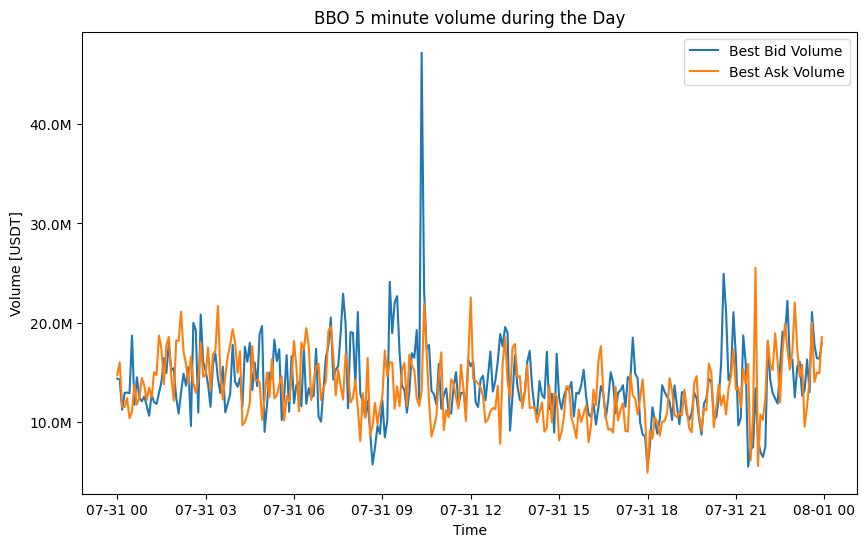

In [14]:
import pandas as pd
from matplotlib.ticker import FuncFormatter
df_pandas = df.to_pandas()

# Convert timestamp to datetime
df_pandas['timestamp'] = pd.to_datetime(df_pandas['timestamp'])

# Set timestamp as index
df_pandas.set_index('timestamp', inplace=True)

# Resample the data to hourly intervals and sum the volumes
hourly_volume = df_pandas.resample('5min').median()

# Plot the volume distribution
plt.figure(figsize=(10, 6))
plt.plot(hourly_volume.index, hourly_volume['best_bid_vol'], label='Best Bid Volume')
plt.plot(hourly_volume.index, hourly_volume['best_ask_vol'], label='Best Ask Volume')
plt.xlabel('Time')
plt.ylabel('Volume [USDT]')
plt.title('BBO 5 minute volume during the Day')
plt.legend()
# Apply the formatter to the y-axis
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

In [3]:
from scripts.strategy.market_imbalance import MarketImbalanceStrategy,AssetInfo, RiskManager
from hftbacktest import (
    Recorder
)

from hftbacktest import HashMapMarketDepthBacktest

hbt = HashMapMarketDepthBacktest([asset])
recorder = Recorder(1, 30_000_000)

depth = hbt.depth(0)
asset_info = AssetInfo(0,depth.tick_size,depth.lot_size)
risk_manager = RiskManager(asset_info, 1_000_000)
interval = 1_000_000_000 # 1s
window = 3_600_000_000_000 / interval # 1hour


strategy = MarketImbalanceStrategy(asset_info, risk_manager, interval)

strategy.run(hbt,recorder.recorder)

hbt.close()

recorder.to_npz('../output/market_imbalance_ethusdt.npz')


/Users/juanobligado/Library/Caches/pypoetry/virtualenvs/hft-challenge-tFh1-2uG-py3.12/lib/python3.12/site-packages/numba/typed/typeddict.py:39: NumbaTypeSafetyWarning: unsafe cast from int64 to uint64. Precision may be lost.
  return d[key]


### Now we generated the backtest data we can load it and analyze the results.



In [6]:
import numpy as np
from hftbacktest.stats import LinearAssetRecord
data = np.load('../output/market_imbalance_ethusdt.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats()
)
stats.summary()

#stats.plot()


start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTradingValue,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-07-31 00:00:00,2024-07-31 23:55:00,8.405066,13.38393,23877.741463,20116.916204,299.038328,2.9904e8,1.186948,0.00008,2.0128e6
